## **Implementing a GAN from scratch**


In [1]:
!pip3 install torch transformers tensorflow torchvision pandas tokenizers

In [2]:
import torch
print(torch.__version__)

2.8.0+cu126


In [3]:
print("GPU Available:", torch.cuda.is_available())

GPU Available: True


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Implementing the generator and the discriminator networks**

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# define the function for the generator:
def make_generator_network(
        input_size: int = 20,
        num_hidden_layers: int = 1,
        num_hidden_units: int = 100,
        num_output_units: int = 784):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f"fc_g{i}",
                         nn.Linear(input_size, num_hidden_units))
        model.add_module(f"relu_g{i}",
                         nn.LeakyReLU())
        input_size = num_hidden_units

    model.add_module(f"fc_g{num_hidden_layers}",
                     nn.Linear(input_size, num_output_units))
    model.add_module('tanh_g', nn.Tanh())
    return model


# define a function for the discriminator
def make_discriminator_network(
        input_size,
        num_hidden_layers: int = 1,
        num_hidden_units: int = 100,
        num_output_units: int = 1):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f"fc_d{i}",
                         nn.Linear(input_size, num_hidden_units, bias=False))
        model.add_module(f"relu_d{i}", nn.LeakyReLU())
        model.add_module('dropout', nn.Dropout(p=0.5))
        input_size = num_hidden_units
    model.add_module(f"fc_d{num_hidden_layers}",
                     nn.Linear(input_size, num_output_units))
    model.add_module('sigmoid', nn.Sigmoid())
    return model


- image size of the `MNIST` dataset is `28x28` pixels.
- the input vector size is `20`.
- hidden layer of `100` units in each network.

In [14]:
image_size = (28, 28)
z_size = 20

gen_hidden_layers = 1
disc_hidden_layers = 1

gen_hidden_units = 100
disc_hidden_units = 100

torch.manual_seed(1)
gen_model = make_generator_network(
    input_size = z_size,
    num_hidden_layers = gen_hidden_layers,
    num_hidden_units = gen_hidden_units,
    num_output_units = np.prod(image_size)
)

print(gen_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


In [15]:
disc_model = make_discriminator_network(
    input_size = np.prod(image_size),
    num_hidden_layers = disc_hidden_layers,
    num_hidden_units = disc_hidden_units)
print(disc_model)

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### **Defining the training dataset**


- For training our `GAN` model, we will use the `MNIST` dataset, which consists of grayscale images of handwritten digits (0-9). The dataset contains `60,000` training images and `10,000` test images, each with a resolution of `28x28` pixels.
- We will normalize the pixel values to the range `[-1, 1]` to match the output range of the generator network, which uses the `Tanh` activation function in its output layer.
- This normalization helps the generator produce outputs that are more realistic and consistent with the training data distribution.
- Use `torchvision.transforms.ToTensor` to convert images to PyTorch tensors and `torchvision.transforms.Normalize` to scale pixel values to the desired range.

In [16]:
import torchvision
from torchvision import transforms

image_path = './'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = torchvision.datasets.MNIST(
    root=image_path,
    train=True,
    download=True,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.01MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 140kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.9MB/s]


In [17]:
example, label = next(iter(mnist_dataset))
print(f'Min: {example.min()} Max: {example.max()}')
print(example.shape)

Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


- We will create a random vector, $z$, based on the desired random distribution:

In [18]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)
    return input_z

- process a forward pass for our generator and discriminator.


- First, we will feed the batch of input, $z$, vectors to the generator and get its output, `g_output`. This will be a batch of fake examples, which will be fed to the `discriminator` model to get the probabilities for the batch of fake examples, `d_proba_fake`. Furthermore, the processed images that we get from the
dataset object will be fed to the discriminator model, which will result in the probabilities for the real examples, `d_proba_real`. The code is as follows:

In [25]:
from torch.utils.data import DataLoader

batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
input_real = input_real.view(input_real.size(0), -1)
print(input_real.size())

torch.Size([32, 784])


In [26]:
torch.manual_seed(1)
mode_z = 'uniform' # 'uniform' vs. 'normal'
input_z = create_noise(batch_size, z_size, mode_z)
print('input-z -- shape:', input_z.shape)
print('input-real -- shape:', input_real.shape)

input-z -- shape: torch.Size([32, 20])
input-real -- shape: torch.Size([32, 784])


In [27]:
g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_proba_real.shape)
print('Disc. (fake) -- shape:', d_proba_fake.shape)

Output of G -- shape: torch.Size([32, 784])
Disc. (real) -- shape: torch.Size([32, 1])
Disc. (fake) -- shape: torch.Size([32, 1])


- The two probabilities, `d_proba_fake` and `d_proba_real`, will be used to compute the loss functions for training the model.

### **Training the GAN model**

- create an instance of `nn.BCELoss` as our loss function and use that to calculate the binary cross-entropy loss for the `generator` and `discriminator` associated with the batches that we just processed.

- Also need the ground truth labels for each output.

- create a vector of `1s` for the `generator` with the same shape as the vector containing the predicted probabilities for the generated images, `d_proba_fake`.

- For the discriminator loss, we have two terms: the loss of detecting the fake examples involving `d_proba_fake` and the loss for detecting the real examples based on `d_proba_real`.

- The ground truth for the fake term will be a vector of `0s` that we can generate via the `torch.zeros()` (or `torch.zeros_like()`) function.

- Similarly, we can generate the ground truth values for the real images via the `torch.ones()` (or `torch.ones_like()`) function.

In [28]:
loss_fn = nn.BCELoss()

## Loss for the Generator
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f"Generator Loss: {g_loss:.4f}")

Generator Loss: 0.6944


In [29]:
## Loss for the Discriminator
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)

d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f'Discriminator Losses: Real {d_loss_real:.4f} Fake {d_loss_fake:.4f}')

Discriminator Losses: Real 0.7758 Fake 0.6924


**Final training**

- The previous code example shows the step-by-step calculation of the different loss terms for the purpose
of understanding the overall concept behind training a GAN model.

- implement the training loop.

- We will start with setting up the `data loader` for the real dataset, the `generator` and `discriminator` model, as well as a separate `Adam optimizer` for each of the two models:

In [30]:
batch_size = 64

torch.manual_seed(1)
np.random.seed(1)

## Set up the dataset
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size,
                      shuffle=True, drop_last=True)

## Set up the models
gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_units,
    num_output_units=np.prod(image_size)).to(device)

disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_units).to(device)

## Loss function and optimizers:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

- In addition, we will compute the `loss` gradients with respect to the model weights and optimize the parameters of the generator and discriminator using two separate `Adam optimizers`.

- We will write two utility functions for training the `discriminator` and the `generator` as follows:

In [31]:
## Train the discriminator
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [32]:
## Train the generator
def g_train(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

- Next, we will alternate between the training of the `generator` and the `discriminator` for 100 epochs.

- For each epoch, we will record the loss for the `generator`, the loss for the `discriminator`, and the loss for the `real data` and `fake data` respectively.

- Furthermore, after each epoch, we will generate some examples from a fixed noise input using the current generator model by calling the `create_samples()`
function.


- We will store the synthesized images in a Python list.

In [33]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

epoch_samples = []

all_d_losses = []
all_g_losses = []

all_d_real = []
all_d_fake = []

num_epochs = 100
torch.manual_seed(1)
for epoch in range(1, num_epochs+1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
          f' [D-Real: {all_d_real[-1]:.4f} D-Fake: {all_d_fake[-1]:.4f}]')
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 0.8944/0.9068 [D-Real: 0.8035 D-Fake: 0.4717]
Epoch 002 | Avg Losses >> G/D 0.9469/1.1271 [D-Real: 0.6164 D-Fake: 0.4318]
Epoch 003 | Avg Losses >> G/D 0.9596/1.1998 [D-Real: 0.5790 D-Fake: 0.4277]
Epoch 004 | Avg Losses >> G/D 0.9415/1.2163 [D-Real: 0.5737 D-Fake: 0.4305]
Epoch 005 | Avg Losses >> G/D 0.9270/1.2284 [D-Real: 0.5705 D-Fake: 0.4286]
Epoch 006 | Avg Losses >> G/D 0.9453/1.2473 [D-Real: 0.5620 D-Fake: 0.4335]
Epoch 007 | Avg Losses >> G/D 1.0020/1.1734 [D-Real: 0.5897 D-Fake: 0.4058]
Epoch 008 | Avg Losses >> G/D 1.0015/1.1883 [D-Real: 0.5890 D-Fake: 0.4110]
Epoch 009 | Avg Losses >> G/D 0.9548/1.2096 [D-Real: 0.5805 D-Fake: 0.4229]
Epoch 010 | Avg Losses >> G/D 0.9074/1.2498 [D-Real: 0.5619 D-Fake: 0.4359]
Epoch 011 | Avg Losses >> G/D 0.9841/1.2001 [D-Real: 0.5831 D-Fake: 0.4135]
Epoch 012 | Avg Losses >> G/D 0.9437/1.2165 [D-Real: 0.5803 D-Fake: 0.4267]
Epoch 013 | Avg Losses >> G/D 0.9947/1.1981 [D-Real: 0.5860 D-Fake: 0.4148]
Epoch 014 | 

- plot the `discriminator` and `generator` losses to analyze the behavior of both subnetworks and assess whether they converged.

- It is also helpful to plot the average probabilities of the batches of real and fake examples as computed by the discriminator in each iteration.

- We expect these probabilities to be around `0.5`, which means that the discriminator is not able to confidently distinguish between real and fake images.

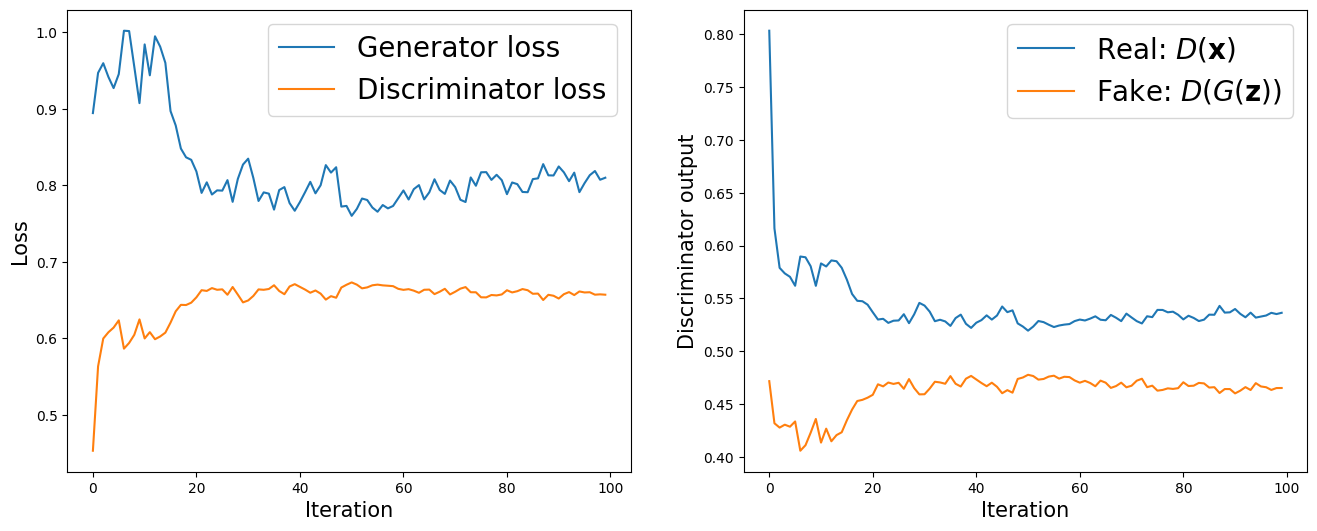

In [34]:
import itertools


fig = plt.figure(figsize=(16, 6))

## Plotting the losses
ax = fig.add_subplot(1, 2, 1)

plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

#plt.savefig('figures/ch17-gan-learning-curve.pdf')
plt.show()

- As you can see from the discriminator outputs in the previous figure, during the early stages of the training, the discriminator was able to quickly learn to distinguish quite accurately between the real and fake examples; that is, the fake examples had probabilities close to `0`, and the real examples had
probabilities close to `1`. The reason for that was that the fake examples were nothing like the real ones; therefore, distinguishing between real and fake was rather easy. As the training proceeds further, the generator will become better at synthesizing realistic images, which will result in probabilities of both
real and fake examples that are close to `0.5`.


- Furthermore, we can also see how the outputs of the generator, that is, the synthesized images, change during training.

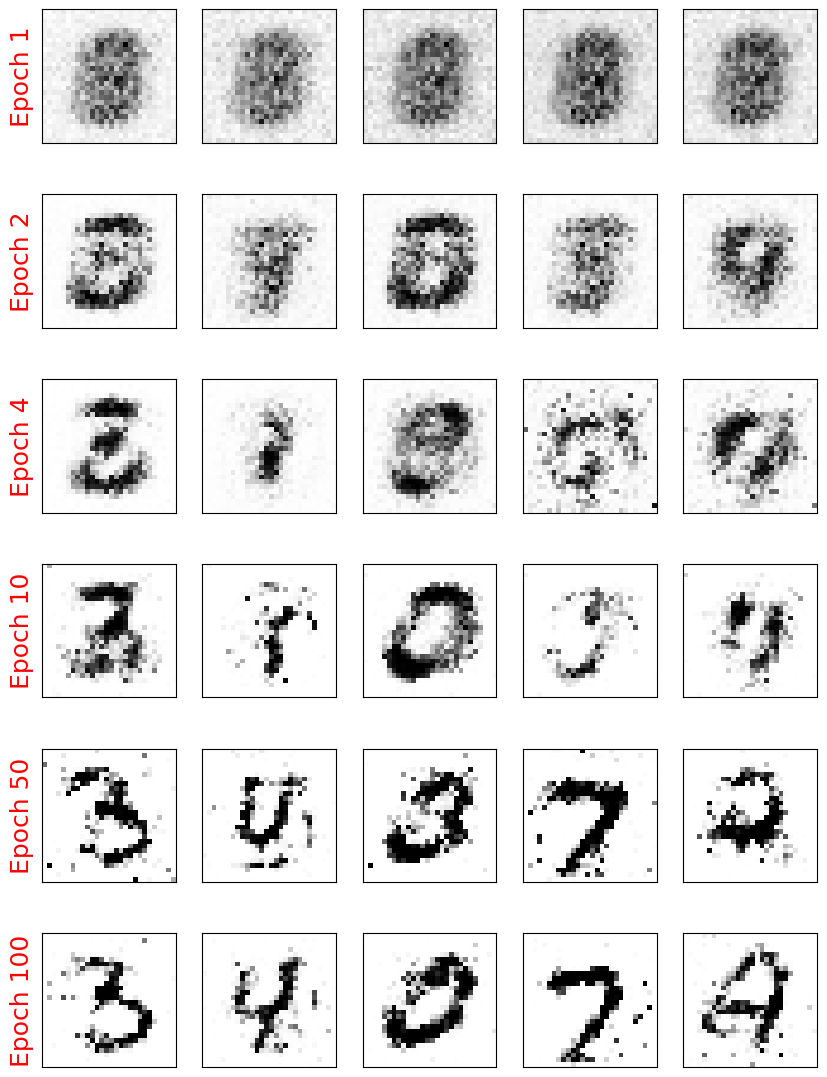

In [35]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

#plt.savefig('figures/ch17-vanila-gan-samples.pdf')
plt.show()

- As you can see from the figure above, the `generator` network produced more and more realistic images as the training progressed. However, even after `100 epochs`, the produced images still look very different from the handwritten digits contained in the MNIST dataset.

- In this section, we designed a very simple `GAN` model with only a single fully connected hidden layer for both the `generator` and `discriminator`. After training the `GAN` model on the `MNIST dataset`, we were able to achieve promising, although not yet satisfactory, results with the new handwritten digits.

- Adding convolutional layers to our `GAN` model to work with image data might improve the outcome.

---


In [36]:
import math


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX,-1).cuda()
    X2 = (X*X).sum(1).resize_(nX,1)
    Y = Y.view(nY,-1).cuda()
    Y2 = (Y*Y).sum(1).resize_(nY,1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX,nY) + Y2.expand(nY,nX).transpose(0,1) - 2*torch.mm(X,Y.transpose(0,1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M+M.abs())/2).sqrt()

    return M

In [37]:
def mmd(Mxx, Mxy, Myy, sigma) :
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx/(scale*2*sigma*sigma))
    Mxy = torch.exp(-Mxy/(scale*2*sigma*sigma))
    Myy = torch.exp(-Myy/(scale*2*sigma*sigma))
    a = Mxx.mean()+Myy.mean()-2*Mxy.mean()
    mmd = math.sqrt(max(a, 0))

    return mmd

In [38]:
def compute_score(fake, real , k=1, sigma=1, sqrt=True):

    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)


    print(mmd(Mxx, Mxy, Myy, sigma))

In [39]:
whole_dl = DataLoader(mnist_dataset, batch_size=10000,
                      shuffle=True, drop_last=True)

In [40]:
real_image = next(iter(whole_dl))[0]

In [41]:
compute_score(torch.from_numpy(epoch_samples[-1]), real_image)

0.8994907011004168


---